# Neural Dependency Parsing




Code Written by:


*   **Riccardo Rosalen** | **Student ID: 2055530** | **E-Mail Address: riccardo.rosalen@studenti.unipd.it**
*   **Federico Violin** | **Student ID: 2061746** | **E-Mail Address: federico.violin.1@studenti.unipd.it**



#Installing Necessary Libraries




*   **datasets**-->huggingface library with dataset
*   **conllu**-->aux library for processing CoNLL-U format
*   **transformers**-->library containing pre-trained BERT model


In [ ]:
!pip install datasets
!pip install conllu
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from functools import partial
from tqdm import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModel, BertModel

##Dataset
In this section, we import a dataset from HuggingFace's Universal Dependencies repository.
Most of the datasets present a big issue, that is that for some sentencies, in the columnt "head" we find between the words' indices also the "None" value. To overcome this issue we implemented the *remove_none_ids* function.
Additional functions for creating a dictionary from the dataset and to filter only projective sentences are implemented below.

We selected the ***UD_Spanish-AnCora*** dataset. The choice of a spanish dataset comes from the fact that this language is the third most spoken in the world only considering people's native languages. In addition, it's still third also considering people's second language. So it should an important object of study for its coverage around the world.
The choice of this particular dataset comes from its variety (we can find news, legal text and also literature).

In [ ]:
def remove_none_ids(dataset):
    filtered_dataset = []
    for sentence in dataset:
        if all(id != "None" for id in sentence['head']):
            filtered_dataset.append(sentence)
    return filtered_dataset

#This function checks if a sentence is projective
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

#Creates a dictionary from the dataset
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [ ]:
#Loading the train/validation/test datasets
train_dataset = load_dataset('universal_dependencies', 'es_ancora', split="train")
val_dataset = load_dataset('universal_dependencies', 'es_ancora',split="validation")
test_dataset = load_dataset('universal_dependencies', 'es_ancora', split="test")

#Many datasets have None value, we check if is present and in case we delete them
train_dataset=remove_none_ids(train_dataset)
val_dataset=remove_none_ids(val_dataset)
test_dataset=remove_none_ids(test_dataset)

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
val_dataset = [sample for sample in val_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
test_dataset = [sample for sample in test_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/14305 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1654 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1721 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/es_ancora/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


In [ ]:
#From any dataset obtain: longest sentence, average sentence length and
#sentence length distribution
def dataset_stats(dataset):
  max_length=0
  sum_length=0
  for sentence in dataset:
    sum_length+=len(sentence["head"])
    if(max_length<len(sentence["head"])):
      max_length=len(sentence["head"])
  bins= list(0 for i in range(max_length+1))
  for sentence in dataset:
    bins[len(sentence["head"])]+=1

  return bins, max_length, sum_length/len(dataset)

#Print an histogram that represents the sentence lenght distribution
def get_histogram(histogram, max_len):
  # Generating histogram
  plt.bar(range(len(histogram)), histogram)
  plt.xlabel('Sentence Length')
  plt.ylabel('Frequency')
  plt.title('Histogram of Sentence Lengths')
  x_ticks = range(max_len)
  x_labels = [str(i) if i % 10 == 0 else '' for i in x_ticks]  # Show labels for even indices only
  plt.xticks(x_ticks, x_labels)
  plt.show()



----------Datasets Statistics----------

TRAINING SET


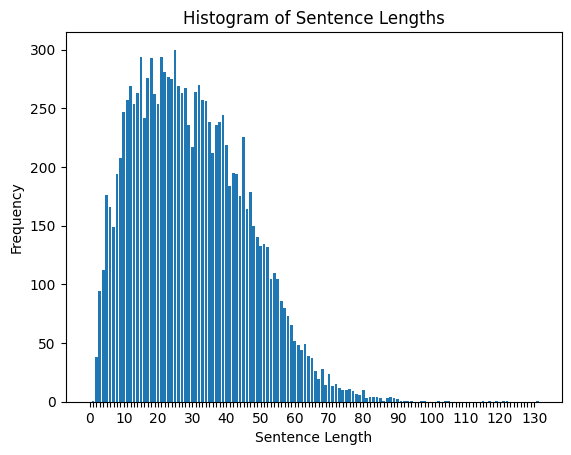

Sentences in training set:	 12321
Longest Sentence: 131
Average Sentence Lenght: 29.870789708627548

VALIDATION SET


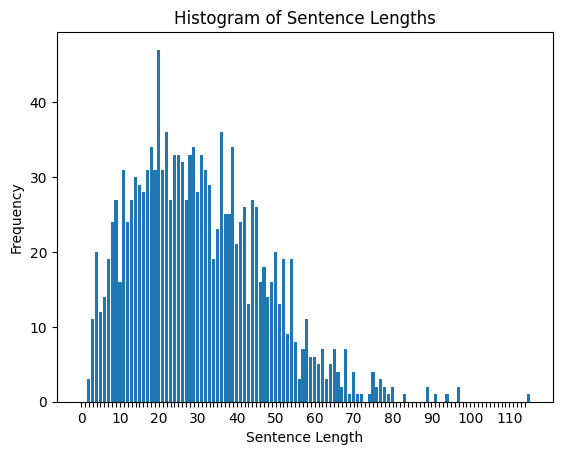

Sentences in validation set:	 1419
Longest Sentence: 115
Average Sentence Length: 30.4538407329105

TEST SET


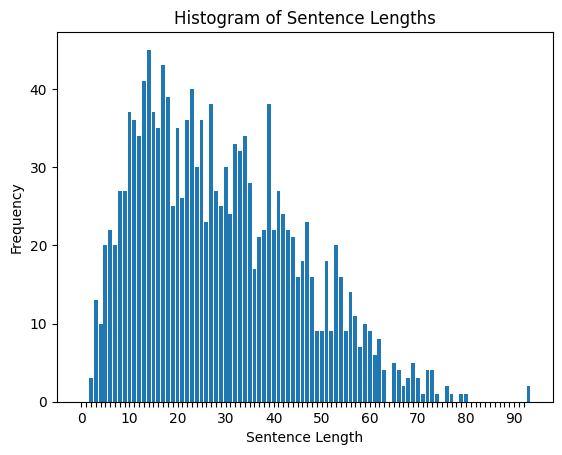

Sentences in validation set:	 1496
Longest Sentence: 93
Average Sentence Length: 28.982620320855617


In [ ]:
print("----------Datasets Statistics----------")
print("\nTRAINING SET")
#Get statistics examinating dataset
tr_histogram,tr_max_length,tr_avg_length=dataset_stats(train_dataset)
#Print histogram
get_histogram(tr_histogram,tr_max_length)
print("Sentences in training set:\t", len(train_dataset))
print("Longest Sentence:",tr_max_length)
print("Average Sentence Lenght:",tr_avg_length)


#----------VALIDATION SET
print("\nVALIDATION SET")
#Get statistics examinating dataset
val_histogram,val_max_length,val_avg_length=dataset_stats(val_dataset)
#Print histogram
get_histogram(val_histogram,val_max_length)
print("Sentences in validation set:\t", len(val_dataset))
print("Longest Sentence:",val_max_length)
print("Average Sentence Length:",val_avg_length)


#----------VALIDATION SET
print("\nTEST SET")
#Get statistics examinating dataset
ts_histogram,ts_max_length,ts_avg_length=dataset_stats(test_dataset)
#Print histogram
get_histogram(ts_histogram,ts_max_length)
print("Sentences in validation set:\t", len(test_dataset))
print("Longest Sentence:",ts_max_length)
print("Average Sentence Length:",ts_avg_length)




# ArcEager Parser

In the task of dependency parsing we can use different strategies to produce the final dependency tree.

The ArcEager parser differs from the ArcStandard Parser by 2 substantial concepts:
* the Reduce operator;
* the fact that leftArc and rightArc operations are made between the first element of the buffer and the last element of the stack, instead of being between the last two elements of the stack.

So the operators for ArcEager parser are 4:
* **Left Arc**:(for any dependency label l) adds the arc (b, l, s) to A, where s is
the node on top of the stack and b is the first node in the buffer, and pops the stack. It has
as a precondition that the token s is not the artificial root node 0 and does not already
have a head.
* **Right Arc**:(for any dependency label l) adds the arc (s, l, b) to A, where s is
the node on top of the stack and b is the first node in the buffer, and pushes the node b
onto the stack.
* **Shift**:pops the stack and is subject to the preconditions that the top
token has a head.
* **Reduce**:removes the first node in the buffer and pushes it onto the stack.

In [ ]:
class ArcEager:
  def __init__(self, sentence):
    #Initialization for the class that manages the ArcEager parser operators
    #Sentence to compute dependencies for
    self.sentence = sentence

    #Buffer containing the words in the sentence
    self.buffer = [i for i in range(len(self.sentence))]

    #Initialize the stack as an empty list
    self.stack = []

    #This variable is used to store the transitions(i.e. the arcs) between words
    self.arcs = [-1 for _ in range(len(self.sentence))]

    #In this case we need only to move the root to the stack
    if len(self.sentence) > 1:
      self.shift()
  #LeftArc:last element of the stack depends on the first element in the buffer
  #Remove from the stack the last element (pop)
  def left_arc(self):
    o1 = self.stack.pop()
    o2 = self.buffer[0]
    self.arcs[o1] = o2

  #RightArc:the first element in the buffer depends on last element of the stack
  #Append to the stack the first element of the buffer (shift)
  def right_arc(self):
    o1 = self.stack.pop()
    o2 = self.buffer[0]
    self.arcs[o2] = o1
    self.stack.append(o1)
    self.shift()

  #Shift:move the first element in the buffer to the last position of the stack
  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  #Remove (Pop) the last element of the stack
  def reduce(self):
    if(len(self.stack) > 1):
      b1 = self.stack.pop()


  #Check the ending conditions for the ArcEager parsing
  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0


#ArcEager's Oracle

The oracle is a component used to guide the training of the parser using ground truth. Basically it implements functions that check if the main operators can be applied.

In [ ]:
class Oracle_ArcEager:
  #Initialize the Oracle passing a parser istance and the gold tree
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree


  #Check if the left_arc operator can be applied
  def is_left_arc_gold(self):

    #The head of the dependency should be the first element of the buffer
    #If it doesn't exists, no left_arc can be applied
    if len(self.parser.buffer) == 0:
      return False

    #Assign to o1 the possible head
    o1 = self.parser.buffer[0]

    #Assign to o2 the possible dependent
    o2 = self.parser.stack[len(self.parser.stack)-1]

    #Check in the gold tree if the operations is correct
    if self.gold[o2] == o1 and self.parser.arcs[o1] != self.gold[o1] and o1 != -1:
      return True

    return False


  #Check if the right_arc operator can be applied
  def is_right_arc_gold(self):

    #If buffer is empty we can't do any association
    if len(self.parser.buffer) == 0:
      return False
    else:

      #Assign to o1 the possible head
      o1 = self.parser.stack[len(self.parser.stack)-1]

      #Assign to o2 the possible dependent
      o2= self.parser.buffer[0]

      #Check in the gold tree if the operations is correct
      if self.gold[o2] == o1:
        return True

    return False


  #Check if the reduce operator can be applied
  def is_reduce_gold(self):

    #If no association can be done and stack is not empty
    if len(self.parser.buffer) == 0 and self.parser.stack[len(self.parser.stack)-1] != -1:
      return True

    #Check if left_arc or right_arc can be done, if yes return False
    if(self.is_left_arc_gold() or self.is_right_arc_gold()):
      return False

    #For any element in the stack we check for matches with buffer[0]
    for i in range(len(self.parser.stack)-1):

      o2 = self.parser.stack[i]
      o1 = self.parser.buffer[0]

      if self.gold[o1] == o2 or self.gold[o2] == o1:
        return True

    return False

  #Check if shift operator can be applied
  def is_shift_gold(self):
    #If any other operator can't be applied, shift is the one to use
    if(self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True


## Create training data and iterable dataloaders



We already preprocessed the dataset to fit the task we want to achieve. Below we create a dictionary of word/index pairs, to be used later when creating word embeddings.  Words that have less than three occurrences are not encoded and will later be mapped to special token `<unk>`.
Then we implemented the ***process_sample*** function to create the action sequence to get the gold tree.

In [ ]:
# create the dictionary from the dataset
emb_dictionary = create_dict(train_dataset)

The next function is used to process our data and create the actual training samples.

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.  We then pair configurations and canonical actions.  Since our neural classifier will look only into first element of the buffer and last element of the stack, we do not have to record the full parser configuration, but only those two positions.

In [ ]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"] if i != 'None']  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle_ArcEager(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      #0 means left_arc
      #1 means right_arc
      #2 means reduce
      #3 means shift
      if oracle.is_left_arc_gold():
        parser.left_arc()
        gold_moves.append(0)
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  return enc_sentence, gold_path, gold_moves, gold

Next function used to batch the training data.

In [ ]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

Finally, we create dataloaders for train, development and test sets.

In [ ]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Create neural network model

In this section we describe the details of the implementation of two quite similar models, each one based on a first phase of encoding performed by a Transformer Neural Network (BiLSTM and BERT respectively), then the parsing and the training performed with the use of a Multi-Layer Perceptron(MLP) as a feedforward network.


For clarity sake we separated the two implementations and also we defined the parameter for each one in two different cells like the one below.

In [ ]:
EMBEDDING_SIZE = 100
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2

# BiLSTM-based Network


Next, we create our model. It consists of a Bi-LSTM to represent words together with their contexts and a feedforward network to predict the next move of the parser.
The model is the same as the one presented in the second lab session of the course, apart from some dimensions' values that for compatibily reasons must've changed, like the output of the last layer in the feedforward network or the input of the first layer of the same section.

This model picks a batch of sentences from dataset. embeds it using a BiLSTM, then with a feedforward network learns to predict dependencies using previously defined Oracle and Parser.

The biggest change regards the parse_step function, that is adapted to the ArcEager parser. The details are more comprehensible observing the code, so we provided verbose comments to explain our choice in that part.

In [ ]:
class BiLSTMNet(nn.Module):

  def __init__(self, device):
    super(BiLSTMNet, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    #Input size is LSTM size*4
    #4 because we have 2 entries in the configuration
    #considering bidirectionality we have then 2 configurations for 2 directions->4
    self.w1 = torch.nn.Linear(4*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    #Since there are 4 possibile transitions, the output size of the last layer is 4
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out


  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h


  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input


  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))


  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]


  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  #For each parser in the batch check if they all arrived at a final configuration
  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


  # In this function we select and perform the next move according to the scores obtained.
  # Considering the fact that oracle and parser don't pay too much attention on between
  # which elements are the association performed, this function controls also particular cases
  # Cosidering that is a quite tricky part, the comments will be particularly verbose, to better
  # explain reasoning and the choice we took.
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        #0 is left arc
        if moves_argm[i] == 0:
          # When we have the empty buffer the only choice is to perform reduce
          # We don't have to check if we are reducing the root element because in that
          # case the tree is final
          if len(parsers[i].buffer) == 0:
            parsers[i].reduce()
          else:
            #Now we can perform left arc, but only if the last element of the stack
            #is not the root
            if parsers[i].stack[len(parsers[i].stack)-1] != 0:
              parsers[i].left_arc()
            else:
              #If the last element of the stack is the root we compute the second
              #most probable move predicted and perform it
              #We can't apply reduce, because we would remove the root
              if moves[i][1]>moves[i][3]:
                parsers[i].right_arc()
              else:
                parsers[i].shift()
        # 1 is right arc
        elif moves_argm[i] == 1:
          #In case we have empty buffer, we already know that is not final
          #because the other final condition is to have only root, so we reduce
          if len(parsers[i].buffer) == 0:
            parsers[i].reduce()
          else:
            #right arc can always be performed in this case
            parsers[i].right_arc()
        # 2 is reduce
        elif moves_argm[i] == 2:
          # we can reduce only if we have the root
          if parsers[i].stack[len(parsers[i].stack)-1] != 0:
            parsers[i].reduce()
          else:
            # otherwise we perform the most probable between right arc and shift
            if moves[i][1] > moves[i][3]:
              parsers[i].right_arc()
            else:
              parsers[i].shift()
        #3 is shift
        elif moves_argm[i] == 3:
          #In case we have empty buffer we can only reduce (stack length >1)
          if len(parsers[i].buffer) == 0:
            parsers[i].reduce()
          #If we have only one element shifting will avoid it to be in the tree
          elif len(parsers[i].buffer) == 1:
            #if we have the root the only thing to do is right a dependency
            if parsers[i].stack[len(parsers[i].stack)-1] == 0:
              parsers[i].right_arc()
            else:
              #if we have any two elements, we find the best move (except from shift)
              next_move = moves[i][:2].argmax(-1)
              #find the move associated
              if next_move == 0:
                parsers[i].left_arc()
              elif next_move == 1:
                parsers[i].right_arc()
              else:
                parsers[i].reduce()
          #otherwise shifting is ok
          else:
            parsers[i].shift()

##BERT Network

To realize this part we tried as first thing to modify as less functionality of an already working architecture like the one before.
So basically we tried to substitute the line of code that in the previous class performed the embeddings with exactly one line of code in this class too.

To do this we created the ***bert_embedding*** function that has to perform the embeddings for the sentences in the batch. The functions proceeds in the following way:

For each sentence:
1.   Extracts a full sentence starting from separated words*.
2.   Tokenize it
3.   Exclude sub-words tokens
4.   Obtain a new sentence with only leftmost tokens and append it to a list

Then:
5.  Re-tokenize all the fixed sentences
6.  Get the embeddings from the BERT model and return them to the calling function

Two possible alternatives to this approach are:


*   Using the attention mask to exclude the subtokens and keep only the leftmost tokens (after some tests, it performed slightly worse than our choice)
*   Peform the average of the subtokens of the full word (discarded for simplicity sake)



*The words are obtained from words id using the emb_dictionary. The peculiarity of this dictionary is that the keys are not the ids of the words but are the words themselves, so to look for the right word we must look all the dictionary in the worst case.

The forward function(and also infere) then performs a permutation of the tensor with the batch embeddings, to fit it to the feedforward layers.

To fit the new embeddings to the feedforward model we had to adjust the input size, setting it at 768, that is the dimension of the BERT embeddings for the uncased model.

In [ ]:
BERT_SIZE=768
MLP_SIZE = 200
DROPOUT = 0.2

In [ ]:
class BERTNet(nn.Module):

  def __init__(self, device):
    super(BERTNet, self).__init__()
    self.device = device
    # initialize BERT
    self.model = BertModel.from_pretrained("bert-base-uncased")
    self.model.requires_grad_()  # Set requires_grad to True for all parameters

    #We need to add the following tokens to the tokenizer vocaboulary
    #Otherwise, for example we would have: <ROOT> splitted into "<","root",">"
    #Without this addition system's performances are approximately 0.3 worse in terms of UAS
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    self.tokenizer.add_tokens(["<ROOT>"])
    self.tokenizer.add_tokens(["<unk>"])
    self.tokenizer.add_tokens(["<pad>"])
    self.model.resize_token_embeddings(len(self.tokenizer))

    # initialize feedforward
    # BERT's embedding size is 768 for the uncased model
    # as seen for BiLSTM we have two configurations saved for each entry, so BERT_SIZE*2
    self.w1 = torch.nn.Linear(2*BERT_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    #Here we put output length equal to 4 because it has 4 outputs: left-arc,
    #right-arc, reduce or shift
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.norm1 = nn.LayerNorm(MLP_SIZE)
    self.norm2 = nn.LayerNorm(4)
    self.dropout = torch.nn.Dropout(DROPOUT)


  #Retrieve the word corresponding to the given ID
  # Otherwise the word is not in the dictionary, then we assign <unk>
  def get_key_from_value(self, dictionary, word_id):
      for key, value in dictionary.items():
          if value == word_id:
              return key
      return "<unk>"


  #We perform the embedding for all the sentences in the batch
  def bert_embedding(self, x):
    word_sentences = []
    sentences_to_tokenize = []
    filtered_sentences=[]
    #For each sentence
    for sentence in x:
        #Since the tokenizer performs contextualized embeddings, we have to give it a full sentence
        word_sentence = [self.get_key_from_value(emb_dictionary, word) for word in sentence if word in emb_dictionary.values()]
        word_sentence=" ".join(word_sentence)

        #We tokenize it
        tokens=self.tokenizer.convert_ids_to_tokens(self.tokenizer(word_sentence,add_special_tokens=False)["input_ids"])
        #We keep only the first token if there are some splits
        tokens=[i for i in tokens if not i.startswith("##")]
        #We create another sentence (which will not be splitted)
        word_sentences.append(" ".join(tokens))

    #Re tokenize the full batch of "clean" sentences
    tokenized_sentences = self.tokenizer(word_sentences, add_special_tokens=False, padding=True, return_tensors="pt")
    input_ids = tokenized_sentences["input_ids"].to(self.device)
    attention_mask = tokenized_sentences["attention_mask"].to(self.device)

    # Create the embedding using bert model
    model_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
    return model_output.last_hidden_state


  def forward(self, x, paths):
    # get the embeddings
    x = self.dropout(self.bert_embedding(x)).to(self.device)

    # run the bi-lstm
    h = x.permute(1,0,2)

    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out


  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(BERT_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input


  def mlp(self, x):
    x = self.dropout(x)
    x = self.w1(x)
    x = self.norm1(x)  # Apply layer normalization
    x = self.activation(x)
    x = self.dropout(x)
    x = self.w2(x)
    x = self.norm2(x)  # Apply layer normalization
    x=self.softmax(x)
    return x


  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = (self.dropout(self.bert_embedding(x))).to(self.device)

    h = x.permute(1,0,2)
    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]


  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations


  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


   # In this function we select and perform the next move according to the scores obtained.
  # Considering the fact that oracle and parser don't pay too much attention on between
  # which elements are the association performed, this function controls also particular cases
  # Cosidering that is a quite tricky part, the comments will be particularly verbose, to better
  # explain reasoning and the choice we took.
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        #0 is left arc
        if moves_argm[i] == 0:
          # When we have the empty buffer the only choice is to perform reduce
          # We don't have to check if we are reducing the root element because in that
          # case the tree is final
          if len(parsers[i].buffer) == 0:
            parsers[i].reduce()
          else:
            #Now we can perform left arc, but only if the last element of the stack
            #is not the root
            if parsers[i].stack[len(parsers[i].stack)-1] != 0:
              parsers[i].left_arc()
            else:
              #If the last element of the stack is the root we compute the second
              #most probable move predicted and perform it
              #We can't apply reduce, because we would remove the root
              if moves[i][1]>moves[i][3]:
                parsers[i].right_arc()
              else:
                parsers[i].shift()
        # 1 is right arc
        elif moves_argm[i] == 1:
          #In case we have empty buffer, we already know that is not final
          #because the other final condition is to have only root, so we reduce
          if len(parsers[i].buffer) == 0:
            parsers[i].reduce()
          else:
            #right arc can always be performed in this case
            parsers[i].right_arc()
        # 2 is reduce
        elif moves_argm[i] == 2:
          # we can reduce only if we have the root
          if parsers[i].stack[len(parsers[i].stack)-1] != 0:
            parsers[i].reduce()
          else:
            # otherwise we perform the most probable between right arc and shift
            if moves[i][1] > moves[i][3]:
              parsers[i].right_arc()
            else:
              parsers[i].shift()
        #3 is shift
        elif moves_argm[i] == 3:
          #In case we have empty buffer we can only reduce (stack length >1)
          if len(parsers[i].buffer) == 0:
            parsers[i].reduce()
          #If we have only one element shifting will avoid it to be in the tree
          elif len(parsers[i].buffer) == 1:
            #if we have the root the only thing to do is right a dependency
            if parsers[i].stack[len(parsers[i].stack)-1] == 0:
              parsers[i].right_arc()
            else:
              #if we have any two elements, we find the best move (except from shift)
              next_move = moves[i][:2].argmax(-1)
              #find the move associated
              if next_move == 0:
                parsers[i].left_arc()
              elif next_move == 1:
                parsers[i].right_arc()
              else:
                parsers[i].reduce()
          #otherwise shifting is ok
          else:
            parsers[i].shift()

# Train and Test
Now that we have defined all our components, we are ready to train and test our model.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Next, we define our train loop and the test function to run inference.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
  return total_loss/count


def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred
  return evaluate(gold, preds)

# BiLSTM-based model: Training Parameters



In [ ]:
EPOCHS = 15
LR = 0.001   # learning rate

#BiLSTM Training

We focused more un training the second model, so for what concerns this one we just verified that UAS value was similar to the one obtained by the ArcStandard based model seen in second laboratory session.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = BiLSTMNet(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

bilstm_val_uas=[]
bilstm_train_loss=[]

for epoch in range(EPOCHS):
  bilstm_train_loss.append(train(model, train_dataloader, criterion, optimizer))
  bilstm_val_uas.append(test(model, val_dataloader))
  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, bilstm_train_loss[epoch], bilstm_val_uas[epoch]))

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 0.993 | dev_uas: 0.658 |
Epoch:   1 | avg_train_loss: 0.915 | dev_uas: 0.710 |
Epoch:   2 | avg_train_loss: 0.893 | dev_uas: 0.734 |
Epoch:   3 | avg_train_loss: 0.879 | dev_uas: 0.752 |
Epoch:   4 | avg_train_loss: 0.869 | dev_uas: 0.765 |
Epoch:   5 | avg_train_loss: 0.860 | dev_uas: 0.775 |
Epoch:   6 | avg_train_loss: 0.853 | dev_uas: 0.782 |
Epoch:   7 | avg_train_loss: 0.847 | dev_uas: 0.790 |
Epoch:   8 | avg_train_loss: 0.843 | dev_uas: 0.793 |
Epoch:   9 | avg_train_loss: 0.839 | dev_uas: 0.800 |
Epoch:  10 | avg_train_loss: 0.835 | dev_uas: 0.803 |
Epoch:  11 | avg_train_loss: 0.832 | dev_uas: 0.805 |
Epoch:  12 | avg_train_loss: 0.829 | dev_uas: 0.810 |
Epoch:  13 | avg_train_loss: 0.827 | dev_uas: 0.812 |
Epoch:  14 | avg_train_loss: 0.823 | dev_uas: 0.815 |


And we test on the test set.

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.817


# BERT-based model: Training Parameters

To allow the consecutive execution of the whole notebook (and also to easily control all the hyperparameters) below there are the ones used for the BERT-based pipeline

In [ ]:
EPOCHS = 15
LR = 0.0001  # learning rate

#BERT Training

For this part we tested several combinations of hyperparameters.
Starting from learning rate, we tried starting from 0.01 (the one of the BiLSTM based model) and tested several submultiples and multiples. While 0.01 and its multiple lead to stuck training or completely random results, we found that 0.0001 was the better one. The submultiples instead gave a much slower learning speed.

Another thing we tried was the dropout rate. Starting from the one of the BiLSTM model (0.2) we tried all the step from 0.0 (no dropout) to 0.5 increasing each time by 0.05. At the end we decided to keep the initial dropout since the improvements were not so significant.

We tried editing the feedforward part of the model. Adding layers, changing actual MLP size (both reducing and increasing it) didn't bring a significant improvement. We tried adding Batch Normalization but that didn't improve the performance too.

In addition we tried comparing the performance using the requires_grad on the BERT encoder, that means that when performing the encodings the model updates its weights. This choice too has no particular differences if present or not, but we decided to insert it to have a better fit on our dataset.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = BERTNet(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
bert_val_uas=[]
bert_train_loss=[]

for epoch in range(EPOCHS):
  bert_train_loss.append(train(model, train_dataloader, criterion, optimizer))
  bert_val_uas.append(test(model, val_dataloader))
  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, bert_train_loss[epoch], bert_val_uas[epoch]))

Device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0 | avg_train_loss: 1.081 | dev_uas: 0.725 |
Epoch:   1 | avg_train_loss: 1.010 | dev_uas: 0.763 |
Epoch:   2 | avg_train_loss: 0.983 | dev_uas: 0.782 |
Epoch:   3 | avg_train_loss: 0.964 | dev_uas: 0.793 |
Epoch:   4 | avg_train_loss: 0.948 | dev_uas: 0.805 |
Epoch:   5 | avg_train_loss: 0.931 | dev_uas: 0.809 |
Epoch:   6 | avg_train_loss: 0.919 | dev_uas: 0.814 |
Epoch:   7 | avg_train_loss: 0.908 | dev_uas: 0.810 |
Epoch:   8 | avg_train_loss: 0.899 | dev_uas: 0.814 |
Epoch:   9 | avg_train_loss: 0.889 | dev_uas: 0.819 |
Epoch:  10 | avg_train_loss: 0.882 | dev_uas: 0.822 |
Epoch:  11 | avg_train_loss: 0.874 | dev_uas: 0.821 |
Epoch:  12 | avg_train_loss: 0.868 | dev_uas: 0.823 |
Epoch:  13 | avg_train_loss: 0.863 | dev_uas: 0.824 |
Epoch:  14 | avg_train_loss: 0.856 | dev_uas: 0.825 |


Then we check performances on test set

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.816


# Scores comparison between the two architectures
Below we plot the UAS and training loss for the two models. In the case of our spanish dataset the performances are quite the same between BERT-based and BiLSTM-based.
Most of the times BiLSTM-based model should perform worse than the BERT-based model. This difference by the way is more evident in other datasets like en_lines (we used it to perform part of the tests on hyperparameters because it was smaller),where the difference is even about 0.1 on UAS. This could be due to the bigger amount of features (the size of the embedding in particular) in the second model. The main drawback is the execution time that is approximately 1.5 times more for the BERT-based model.

In [ ]:
indices = np.arange(1, EPOCHS+1)

plt.plot(indices,bert_val_uas, label='bert_val_uas')
plt.plot(indices,bilstm_val_uas, label='bilstm_val_uas')
plt.plot(indices,bert_train_loss, label='bert_train_loss')
plt.plot(indices,bilstm_train_loss, label='bilstm_train_loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(min(indices), max(indices)+1, 1))
plt.legend()

# Comparison with State of the Art




\begin{array}{|c|c|}
\hline
\textbf{Method} & \textbf{UAS}  \\
\hline
 UDPipe 2.0 + mBERT + FLAIR & 0,938\\
\hline
UDify  & 0,923\\
\hline
UDPipe 2.0 & 0,916\\
\hline
BertNet & 0,816 \\
\hline
BiLSTMNet & 0,817\\
\hline
\end{array}


As premise, the scores for the implemented models could vary a bit. We put in the table the ones obtained (and saved with the notebook) with an single execution performed on test set before submission.
Comparing the results we can say that there is plenty of room for improvements, to get near to the SoTA performances, but maybe due to lack of experience we've not been able to find the right ones.